In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/5-inline_holography_3d_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Example 5. Multiparticle tracking in 3D

This method is no longer optimal. We recommend the [LodeSTAR method](../LodeSTAR/07.track_3D_holograph.ipynb) instead.

Trains a U-Net to locate spherical particles in 3d.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import skimage
import skimage.measure

import deeptrack as dt

from deeptrack.extras import datasets

datasets.load("3DTracking")

video = scipy.io.loadmat(r"./datasets/3DTracking/1Every1_2_movie_1.aviProcessedField0.mat")
traces = scipy.io.loadmat(r"./datasets/3DTracking/1Every1_2_movie_1.aviCompletedTraces")
mapping = scipy.io.loadmat(r"./datasets/3DTracking/mapping.mat")["Mapping"].T


IMAGE_SIZE = 128
MIN_Z = 2e-6
MAX_Z = 30e-6
Z_SCALE = 3.45e-7
PIXEL_SCALE = 3.45e-7

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Dataset already downloaded.


## 2. Defining the dataset

Defining the optical device, with Coma aberration.

In [3]:
pupil = dt.HorizontalComa(coefficient=lambda: 0.2 +  0.3*np.random.rand()) >> dt.VerticalComa(coefficient=lambda:-0.2 - np.random.rand()*0.2)

optics = dt.Brightfield(
    NA=1.3,
    wavelength=633e-9,
    magnification=1,
    resolution=lambda magnification: PIXEL_SCALE * magnification,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=1,
    pupil=pupil
)

Defining the particles.

In [4]:
particles = dt.MieSphere(
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    z=lambda: + MIN_Z / PIXEL_SCALE + (np.random.rand() * (MAX_Z / PIXEL_SCALE - MIN_Z / PIXEL_SCALE)),
    position_unit="pixel",
    refractive_index=lambda: 1.45 + np.random.rand() * 0.1,
    radius=lambda: 190e-9 + np.random.rand() * 100e-9,
    L=10,
)
particles = particles ^ (lambda: np.random.randint(2, 8))

Adding noise, illumination gradient and normalization

In [5]:
noise = dt.Poisson(snr=lambda: 7 + np.random.rand() * 10, background=1)

gradient = dt.IlluminationGradient(gradient=lambda: np.random.randn(2)*0.0001)

normalization = dt.NormalizeMinMax(min=lambda:np.random.rand()*0.3, max=lambda min: min + 0.7 + np.random.rand()*0.3)

In [6]:
dataset = optics(particles) >> noise >> gradient >> normalization

Visualizing the dataset

c:\users\gu\deeptrack\deeptrack-2.0\deeptrack\optics.py:207: UserWarning: Likely bad optical parameters. NA / wavelength * resolution * magnification = 0.7085308056872037 should be at most 0.5
To fix, set magnification to 2.0, and downsample the resulting image with dt.AveragePooling((2.0, 2.0, 1))

  warnings.warn(


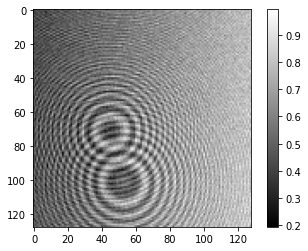

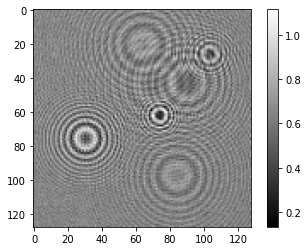

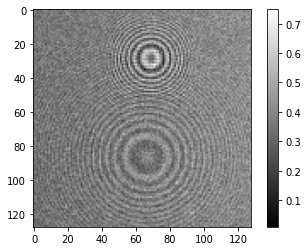

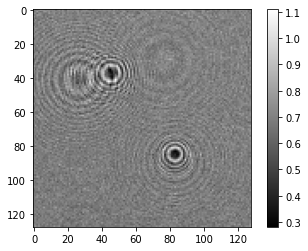

In [7]:
for _ in range(4):
    image = dataset.update().resolve()
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.colorbar()
    plt.show()

## 3. Defining the target

We define the target as a 3D sphere, and use SampleToMasks to position the spheres.

In [8]:
number_of_features = int(MAX_Z / Z_SCALE -  MIN_Z / Z_SCALE)
radius = 5

X, Y, Z = np.mgrid[:radius*2, :radius*2, :radius*2]

SPHERE = (X-radius+0.5)**2 + (Y-radius+0.5)**2 + (Z-radius+0.5)**2 < radius**2

def mask(particle):  
    output = np.zeros((*SPHERE.shape[0:2], number_of_features))
    z = int(np.round(particle.get_property("z") -  MIN_Z / Z_SCALE))
    z0 = np.max([z, 0])
    zs0 = z0 - z
    z1 = np.min([z+SPHERE.shape[2], number_of_features])
    zs1 = z1 - z0
    output[:, :, z0:z1] = SPHERE[:, :, zs0:zs1]
    return output


label = dt.SampleToMasks(
    lambda: mask,
    number_of_masks=number_of_features,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE)
)


def get_label(image):
    return label.update().resolve(image)

C:\Users\GU\AppData\Local\Temp\ipykernel_12564\2287230649.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


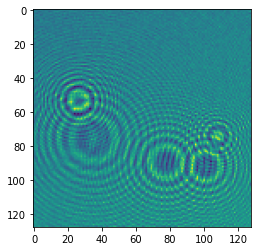

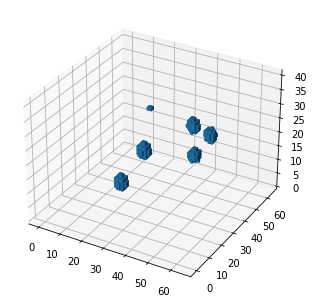

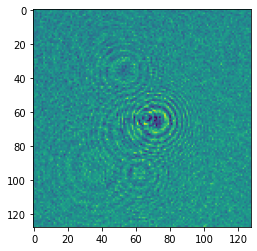

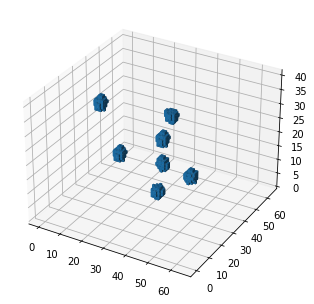

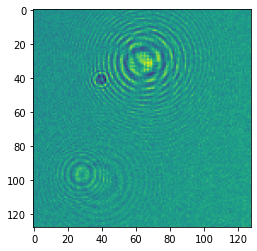

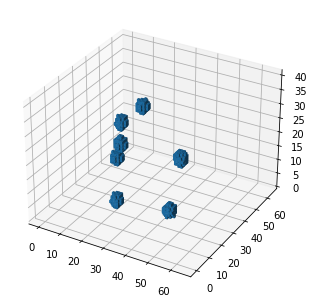

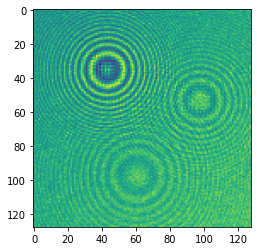

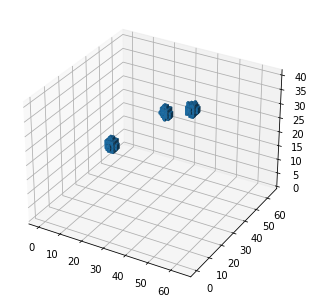

In [9]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 

for _ in range(4):
    image = dataset.update().resolve()
    ground_truth = get_label(image)
    fig = plt.figure()
    plt.imshow(image[:, :, 0])
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.voxels(ground_truth[::2, ::2, ::2])
    plt.show()

## 4. Defining the model

In [10]:
from deeptrack.models import unet
from deeptrack.losses import weighted_crossentropy, nd_mean_squared_error


weight = [20, 1]
model = unet(
    input_shape=(None, None, 1),
    steps_per_pooling=1,
    conv_layers_dimensions=(32, 64, 128,),
    base_conv_layers_dimensions=(128, 128),
    output_conv_layers_dimensions=(64, 64),
    loss=weighted_crossentropy(weight),
    output_activation="sigmoid",
    number_of_outputs=number_of_features,
    metrics=[weighted_crossentropy((1, 1))]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   320         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 activation (Activation)        (None, None, None,   0           ['conv2d[0][0]']                 
                                32)                                                           

## 5. Training the model

In [11]:
TRAIN_MODEL = True

validation_data = []
validation_labels = []
for _ in range(256):
    val_image = dataset.update().resolve()
    val_label = get_label(val_image)
    validation_data.append(val_image)
    validation_labels.append(val_label)

    
validation_set = (
    np.array(validation_data),
    np.array(validation_labels),
)

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset & (dataset >> get_label),
        min_data_size=2000,
        max_data_size=3000,
        batch_size=16,
        max_epochs_per_sample=15
    )

    with generator:

        h = model.fit(generator,
            epochs=50,
            validation_data=validation_set
        )
else:
    path = datasets.load_model("3DTracking")
    model.load_weights(path)

Generating 2000 / 2000 samples before starting training
Epoch 1/50
125/125 [==============================] - 20s 111ms/step - loss: 0.0092 - unet_crossentropy: 0.0404 - val_loss: 0.0059 - val_unet_crossentropy: 0.0193
Epoch 2/50
125/125 [==============================] - 11s 92ms/step - loss: 0.0051 - unet_crossentropy: 0.0175 - val_loss: 0.0037 - val_unet_crossentropy: 0.0151
Epoch 3/50
125/125 [==============================] - 11s 91ms/step - loss: 0.0031 - unet_crossentropy: 0.0128 - val_loss: 0.0024 - val_unet_crossentropy: 0.0102
Epoch 4/50
125/125 [==============================] - 11s 89ms/step - loss: 0.0020 - unet_crossentropy: 0.0096 - val_loss: 0.0017 - val_unet_crossentropy: 0.0080
Epoch 5/50
125/125 [==============================] - 11s 89ms/step - loss: 0.0015 - unet_crossentropy: 0.0078 - val_loss: 0.0014 - val_unet_crossentropy: 0.0062
Epoch 6/50
125/125 [==============================] - 12s 92ms/step - loss: 0.0014 - unet_crossentropy: 0.0069 - val_loss: 0.0012 - v

## 6. Visualizing the results

We visualize the out of plane tracking be comparing the predicted z position of  single trace to that of the off-axis method.

We start by converting the processed fields into a list of images in the real space, and downsample them by a factor of three.

In [12]:
completed_traces = traces["CompletedTraces"]
processed_video = video["ProcessedField"][0]
# Transpose to account for matlab indexing
# mapping = np.transpose(mapping)

vout = []
for idx, frame in enumerate(processed_video):
    
    im = np.zeros(mapping.shape) * 0j
    im[mapping > 0] = frame[:, 0]
    im = np.fft.ifft2(im)
    out = dt.AveragePooling(ksize=(3, 3)).update().resolve(np.abs(im + 1) ** 2, keep_size=False)    
    vout.append(out)

    if idx > 100:
        break
    
vout = np.array(vout)

We pick a single trace and compare the model and the off-axis results.

1/1 [==============================] - 1s 524ms/step


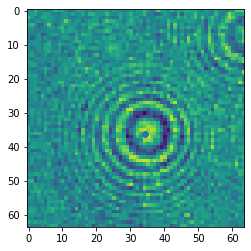

1/1 [==============================] - 0s 14ms/step


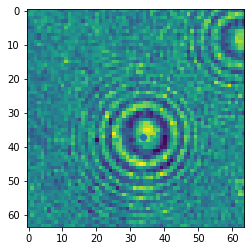

1/1 [==============================] - 0s 14ms/step


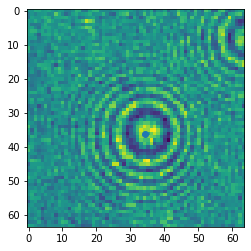

1/1 [==============================] - 0s 14ms/step


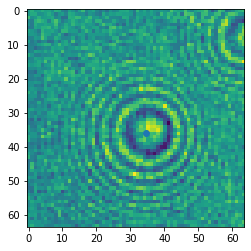

1/1 [==============================] - 0s 14ms/step


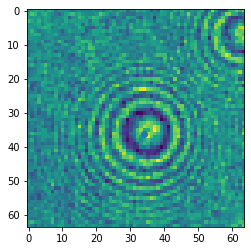

1/1 [==============================] - 0s 13ms/step


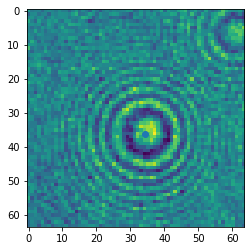

1/1 [==============================] - 0s 14ms/step


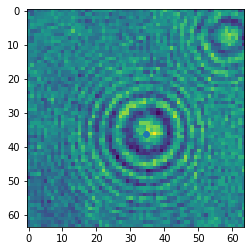

1/1 [==============================] - 0s 17ms/step


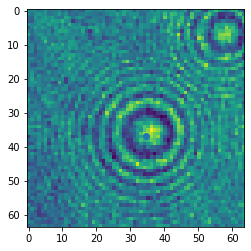

1/1 [==============================] - 0s 14ms/step


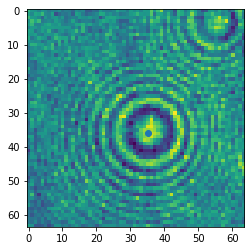

1/1 [==============================] - 0s 13ms/step


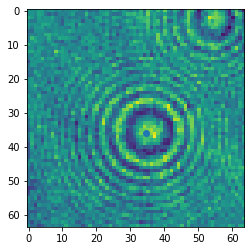

1/1 [==============================] - 0s 14ms/step


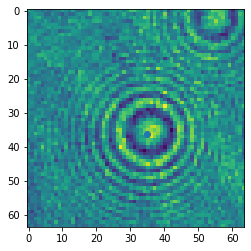

1/1 [==============================] - 0s 13ms/step


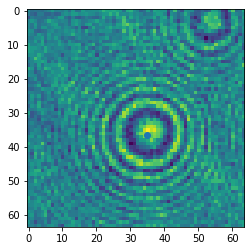

1/1 [==============================] - 0s 13ms/step


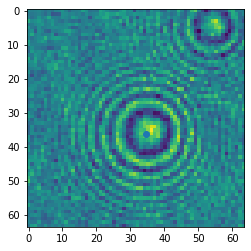

1/1 [==============================] - 0s 13ms/step


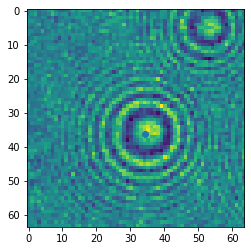

1/1 [==============================] - 0s 13ms/step


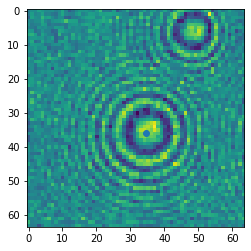

1/1 [==============================] - 0s 14ms/step


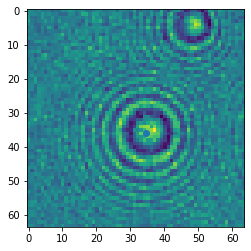

1/1 [==============================] - 0s 14ms/step


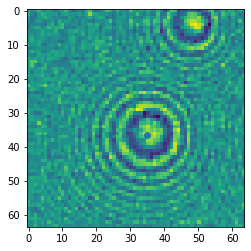

1/1 [==============================] - 0s 14ms/step


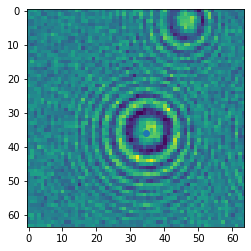

1/1 [==============================] - 0s 13ms/step


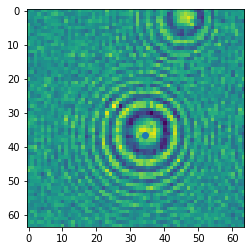

1/1 [==============================] - 0s 14ms/step


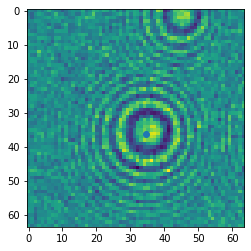

1/1 [==============================] - 0s 13ms/step


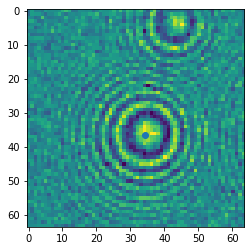

1/1 [==============================] - 0s 13ms/step


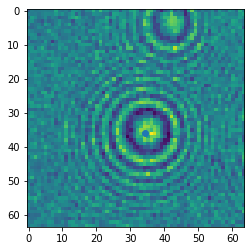

1/1 [==============================] - 0s 14ms/step


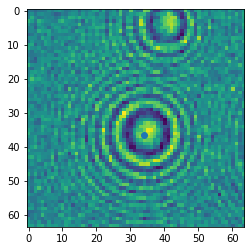

1/1 [==============================] - 0s 14ms/step


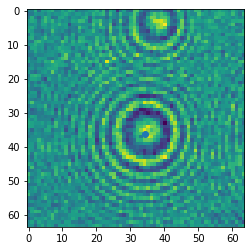

1/1 [==============================] - 0s 14ms/step


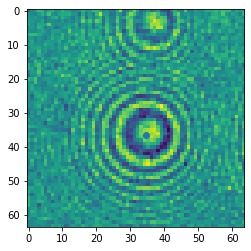

1/1 [==============================] - 0s 14ms/step


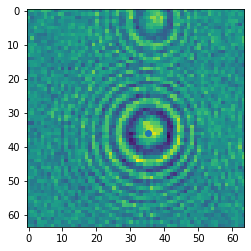

1/1 [==============================] - 0s 15ms/step


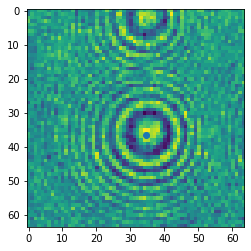

1/1 [==============================] - 0s 13ms/step


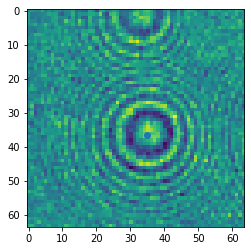

1/1 [==============================] - 0s 14ms/step


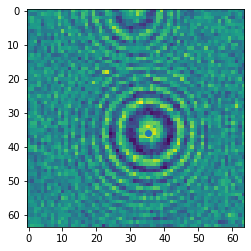

1/1 [==============================] - 0s 14ms/step


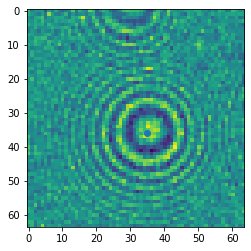

1/1 [==============================] - 0s 13ms/step


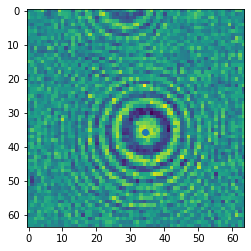

1/1 [==============================] - 0s 14ms/step


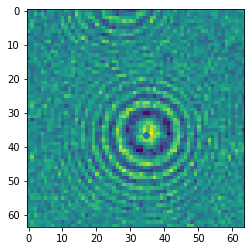

1/1 [==============================] - 0s 13ms/step


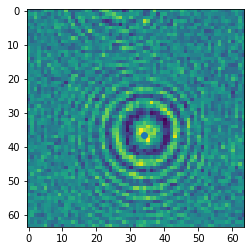

1/1 [==============================] - 0s 13ms/step


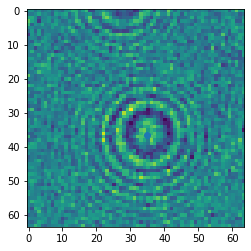

1/1 [==============================] - 0s 14ms/step


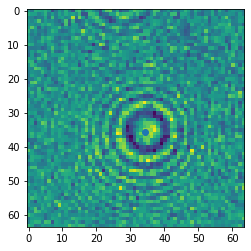

1/1 [==============================] - 0s 14ms/step


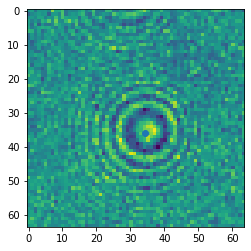

1/1 [==============================] - 0s 14ms/step


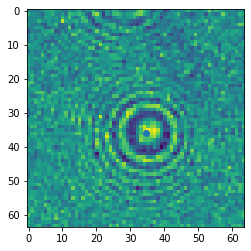

1/1 [==============================] - 0s 14ms/step


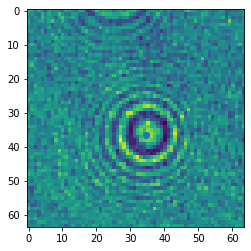

1/1 [==============================] - 0s 14ms/step


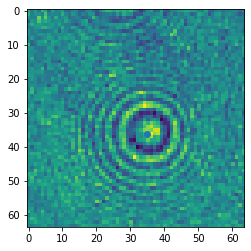

1/1 [==============================] - 0s 14ms/step


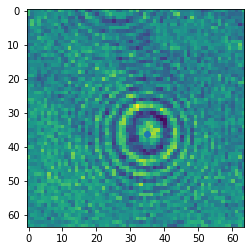

1/1 [==============================] - 0s 14ms/step


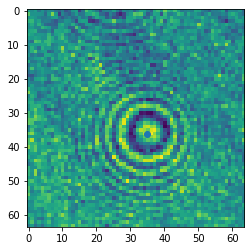

1/1 [==============================] - 0s 14ms/step


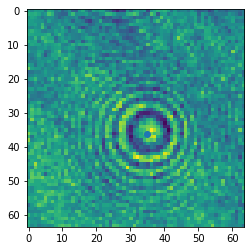

1/1 [==============================] - 0s 14ms/step


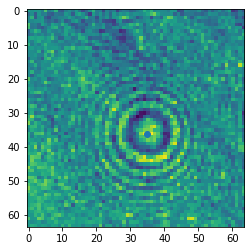

1/1 [==============================] - 0s 14ms/step


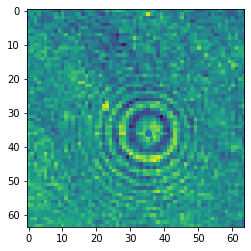

1/1 [==============================] - 0s 14ms/step


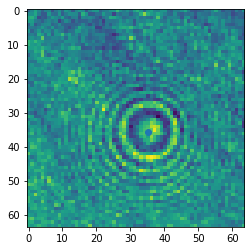

1/1 [==============================] - 0s 13ms/step


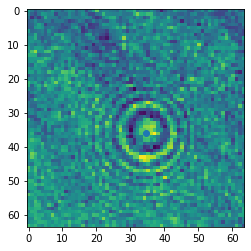

1/1 [==============================] - 0s 14ms/step


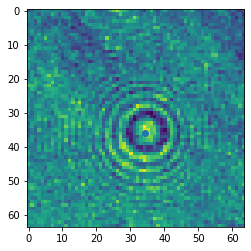

1/1 [==============================] - 0s 14ms/step


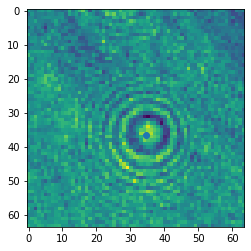

1/1 [==============================] - 0s 14ms/step


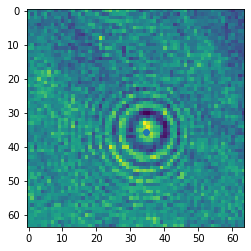

1/1 [==============================] - 0s 13ms/step


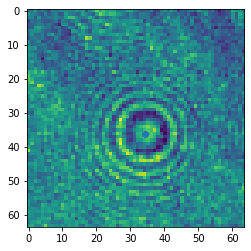

1/1 [==============================] - 0s 13ms/step


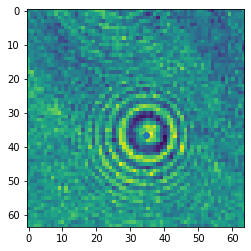

1/1 [==============================] - 0s 14ms/step


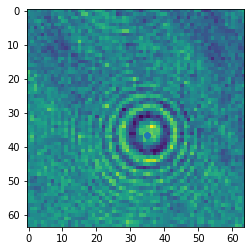

1/1 [==============================] - 0s 14ms/step


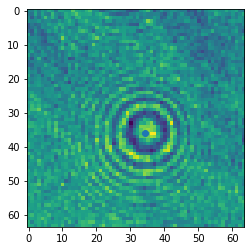

1/1 [==============================] - 0s 13ms/step


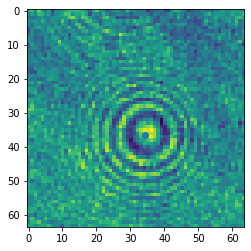

1/1 [==============================] - 0s 14ms/step


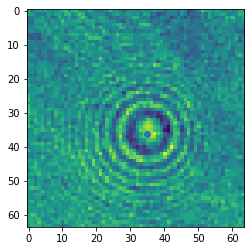

1/1 [==============================] - 0s 14ms/step


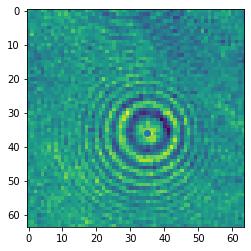

1/1 [==============================] - 0s 14ms/step


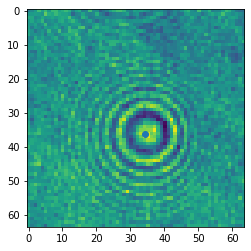

1/1 [==============================] - 0s 14ms/step


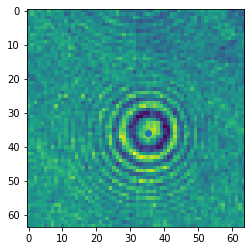

1/1 [==============================] - 0s 14ms/step


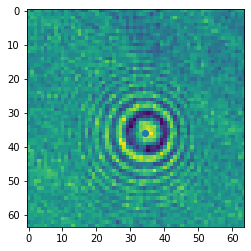

1/1 [==============================] - 0s 14ms/step


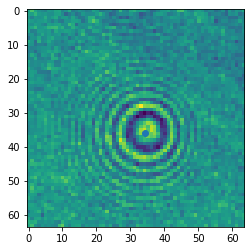

1/1 [==============================] - 0s 14ms/step


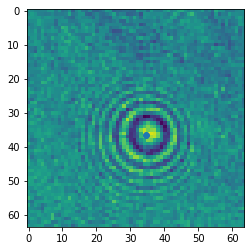

1/1 [==============================] - 0s 14ms/step


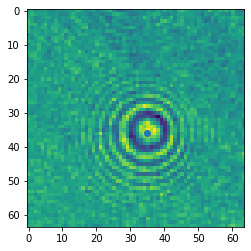

1/1 [==============================] - 0s 13ms/step


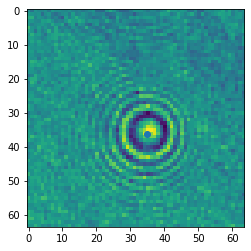

1/1 [==============================] - 0s 14ms/step


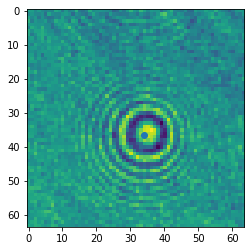

1/1 [==============================] - 0s 13ms/step


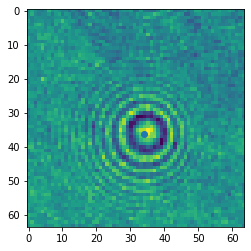

1/1 [==============================] - 0s 14ms/step


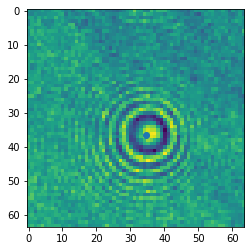

1/1 [==============================] - 0s 14ms/step


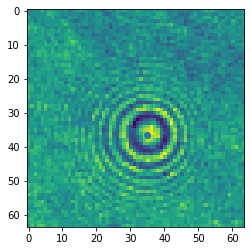

1/1 [==============================] - 0s 13ms/step


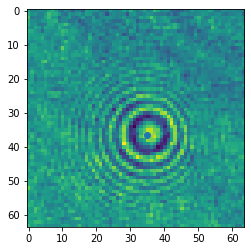

1/1 [==============================] - 0s 14ms/step


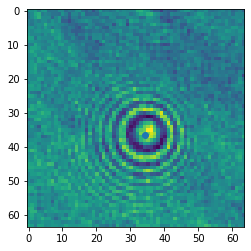

1/1 [==============================] - 0s 14ms/step


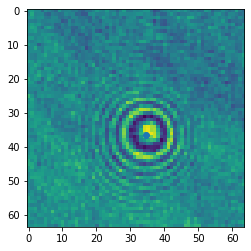

1/1 [==============================] - 0s 13ms/step


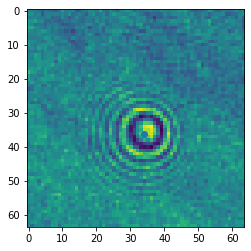

1/1 [==============================] - 0s 14ms/step


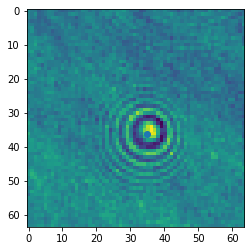

1/1 [==============================] - 0s 14ms/step


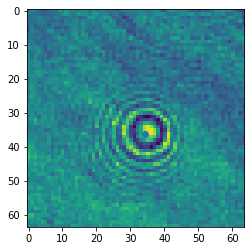

1/1 [==============================] - 0s 13ms/step


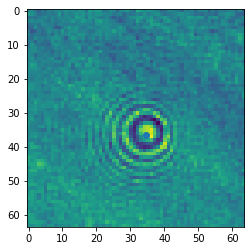

1/1 [==============================] - 0s 13ms/step


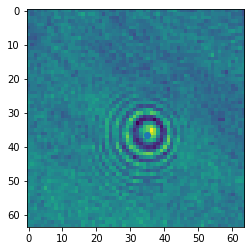

1/1 [==============================] - 0s 14ms/step


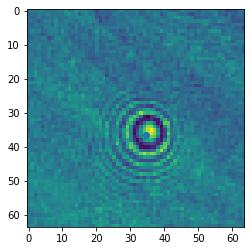

1/1 [==============================] - 0s 14ms/step


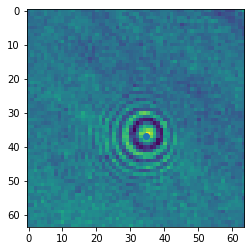

1/1 [==============================] - 0s 13ms/step


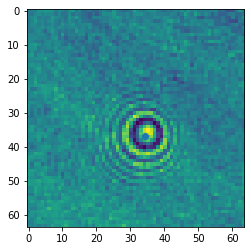

1/1 [==============================] - 0s 14ms/step


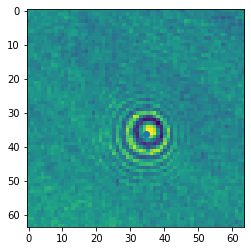

1/1 [==============================] - 0s 14ms/step


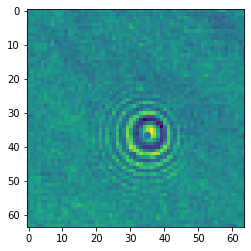

1/1 [==============================] - 0s 14ms/step


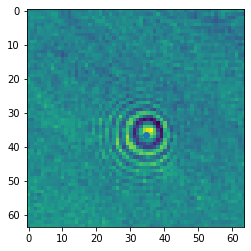

1/1 [==============================] - 0s 14ms/step


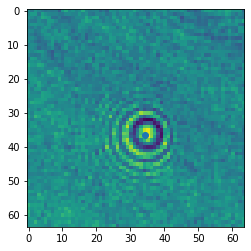

1/1 [==============================] - 0s 14ms/step


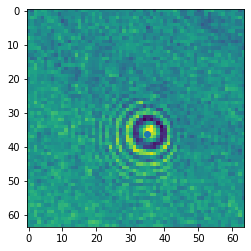

1/1 [==============================] - 0s 14ms/step


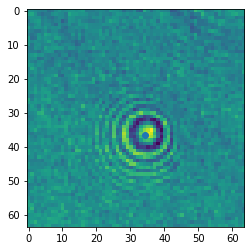

1/1 [==============================] - 0s 14ms/step


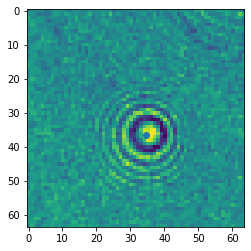

1/1 [==============================] - 0s 14ms/step


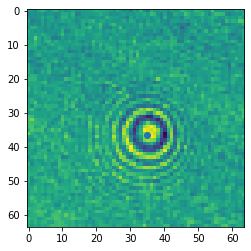

1/1 [==============================] - 0s 14ms/step


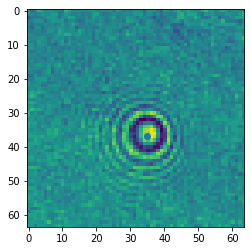

1/1 [==============================] - 0s 14ms/step


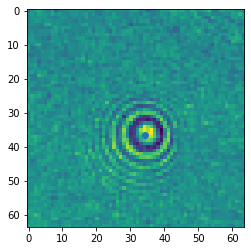

1/1 [==============================] - 0s 14ms/step


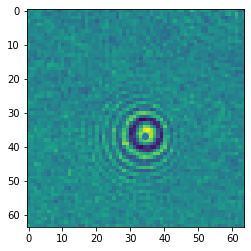

1/1 [==============================] - 0s 14ms/step


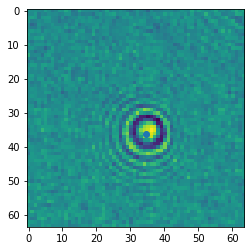

1/1 [==============================] - 0s 13ms/step


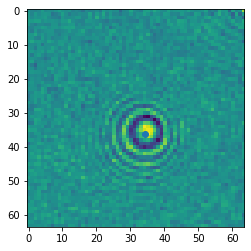

1/1 [==============================] - 0s 14ms/step


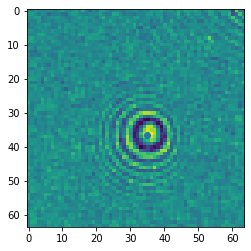

1/1 [==============================] - 0s 14ms/step


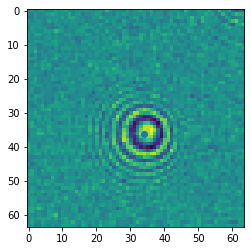

1/1 [==============================] - 0s 15ms/step


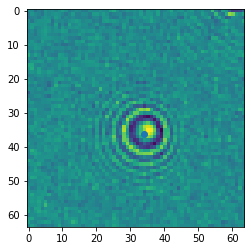

1/1 [==============================] - 0s 13ms/step


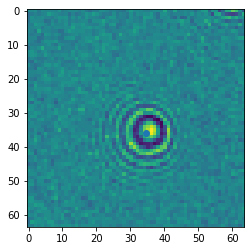

1/1 [==============================] - 0s 14ms/step


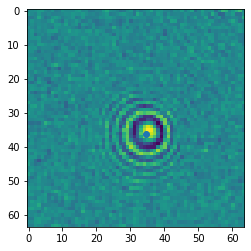

1/1 [==============================] - 0s 14ms/step


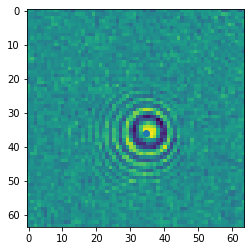

1/1 [==============================] - 0s 14ms/step


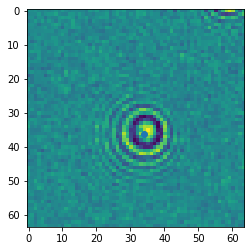

1/1 [==============================] - 0s 14ms/step


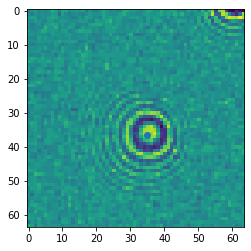

1/1 [==============================] - 0s 14ms/step


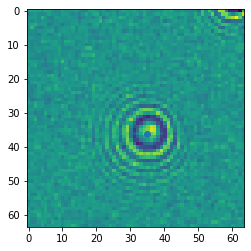

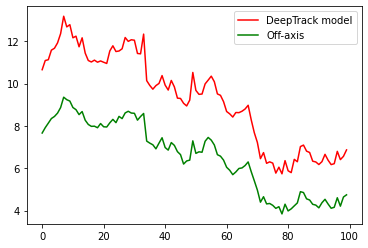

In [13]:


# Odd indexing due to how matlab tables are converted to python objects.
trace = completed_traces[0, 94]
trace = trace[0][0][1]

x = trace[:,1] / 0.115 / 3 
y = trace[:,2] / 0.115 / 3 
z = trace[:,3] 

predicted_z = []
positions = []
frames = []
for i in range(0, 100):

    try:
        t = int(trace[i, 0])
        

        frame = np.expand_dims(vout[i, :, :], axis=-1)
        frame -= np.min(frame)
        frame /= np.max(frame)
        
        frame = frame[int(x[i])-32:int(x[i])+32, int(y[i])-32:int(y[i])+32, :]
        frames.append(frame)
    
        outp = model.predict(np.array([frame])) > 0.75
        CC = skimage.measure.label(outp[0])
        props = skimage.measure.regionprops(CC)
        centroids = [prop["Centroid"] for prop in props]
        idx= np.argmin(np.sum(np.abs(np.array(centroids)[:, :2]-34), axis=1))
        plt.imshow(frame)
        plt.scatter(centroids[idx][1], centroids[idx][0])
        plt.show()
        
        predicted_z.append((centroids[idx][2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6)
        
        c = np.array(centroids[idx])
        c[0] += x[i]
        c[1] += y[i]
        c[2] = (c[2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6
        positions.append(c)

    except Exception as e:
        print(e)
        break

plt.plot(np.array(predicted_z), c="r")
# Multiply by 1.5/1.33 to account for refractive index mismatch between objective and slide.
plt.plot(z[:len(predicted_z)] * 1.5 / 1.33, c="g")

plt.legend(['DeepTrack model', 'Off-axis'])

plt.show()